### Import necessary dependencies

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms.functional as TF
from torchvision.models import vgg19
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import cv2
import random
import numpy as np
from tqdm import tqdm
from imgaug import augmenters as iaa
from glob import glob
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import resize

### Configurations

In [ ]:
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-4
num_epochs = 30
batch_size = 16
scale = 4
patch_size = (96, 96)
gt_patch_size = (96, 96)
lr_patch_size = (96 // scale, 96 // scale)
num_residual_blocks = 16
!unzip data.zip -d ./

Archive:  data.zip
   creating: ./data/Test/
   creating: ./data/Test/Set14/
  inflating: ./data/Test/Set14/baboon.bmp  
  inflating: ./data/Test/Set14/barbara.bmp  
  inflating: ./data/Test/Set14/bridge.bmp  
  inflating: ./data/Test/Set14/coastguard.bmp  
  inflating: ./data/Test/Set14/comic.bmp  
  inflating: ./data/Test/Set14/face.bmp  
  inflating: ./data/Test/Set14/flowers.bmp  
  inflating: ./data/Test/Set14/foreman.bmp  
  inflating: ./data/Test/Set14/lenna.bmp  
  inflating: ./data/Test/Set14/man.bmp  
  inflating: ./data/Test/Set14/monarch.bmp  
  inflating: ./data/Test/Set14/pepper.bmp  
  inflating: ./data/Test/Set14/ppt3.bmp  
  inflating: ./data/Test/Set14/zebra.bmp  
   creating: ./data/Test/Set5/
  inflating: ./data/Test/Set5/baby_GT.bmp  
  inflating: ./data/Test/Set5/bird_GT.bmp  
  inflating: ./data/Test/Set5/butterfly_GT.bmp  
  inflating: ./data/Test/Set5/head_GT.bmp  
  inflating: ./data/Test/Set5/woman_GT.bmp  
   creating: ./data/Train/
  inflating: ./data/Train

Data Augmentation

In [ ]:
import os
import cv2
import numpy as np

from tqdm import tqdm

def augment_images(image_dir):
    # Define augmenters
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Flipud(0.5),  # vertical flips
        iaa.Affine(rotate=(-90, 90)),  # random rotations
        iaa.Crop(percent=(0, 0.2))  # random crops
    ])

    # Get all image file paths in the directory
    image_paths = glob(os.path.join(image_dir, '*'))
    image_paths = [p for p in image_paths if p.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Create augmented images
    for image_path in tqdm(image_paths, desc="Processing images"):
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            continue

        # Apply augmentations
        images_aug = seq(images=[image] * 10)  # Apply 10 augmentations per image

        # Save augmented images
        base_name = os.path.basename(image_path)
        name, ext = os.path.splitext(base_name)
        for i, img_aug in enumerate(images_aug):
            augmented_image_path = os.path.join(image_dir, f"{name}_aug_{i}{ext}")
            cv2.imwrite(augmented_image_path, img_aug)

# Example usage
augment_images("data/Train")


Processing images: 100%|██████████| 100/100 [00:11<00:00,  8.88it/s]


### Preprocessing

In [ ]:
def gt_image_to_patches(image, patch_size):
    channels, height, width = image.size()
    patch_height, patch_width = gt_patch_size
    patches = []

    # Calculate padding needed for width and height
    pad_height = patch_height - height%patch_height
    pad_width = patch_width - width%patch_width

    # Apply the padding
    padded_image = F.pad(image, (0, pad_width, 0, pad_height), mode='constant', value=0)

    # start, stop, step
    for y in range(0, height, patch_height):
        for x in range(0, width, patch_width):
            # the patch consist of all the channels,
            patch = padded_image[:, y:y+patch_height, x:x+patch_width]
            patches.append(patch)


    return patches

In [ ]:
def lr_image_to_patches(image, patch_size):
    channels, height, width = image.size()
    patch_height, patch_width = lr_patch_size
    patches = []

    # Calculate padding needed for width and height
    pad_height = patch_height - height%patch_height
    pad_width = patch_width - width%patch_width

    # Apply the padding
    padded_image = F.pad(image, (0, pad_width, 0, pad_height), mode='constant', value=0)

    # start, stop, step
    for y in range(0, height, patch_height):
        for x in range(0, width, patch_width):
            # the patch consist of all the channels,
            patch = padded_image[:, y:y+patch_height, x:x+patch_width]
            patches.append(patch)


    return patches

In [ ]:
def preprocess_images_in_folder(folder_path, scale, patch_size):

    processed_images = []

    for filename in tqdm(os.listdir(folder_path), desc="Processing images", colour='green') :
        image_path = os.path.join(folder_path, filename)

        input_image = cv2.imread(image_path)

        input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

        # change cv2 BGR to RGB
        GT_tensor = torch.tensor(input_image_rgb, dtype=torch.float32).permute(2,0,1)/255


        GT_image_pil = Image.fromarray(input_image_rgb)
        LR_image_pil = TF.resize(GT_image_pil, [GT_image_pil.size[1] // scale, GT_image_pil.size[0] // scale], interpolation=Image.BICUBIC)

        LR_tensor = TF.to_tensor(LR_image_pil).float()

        LR_patches = lr_image_to_patches(LR_tensor, patch_size)
        GT_patches = gt_image_to_patches(GT_tensor, patch_size)
        processed_images.extend(zip(LR_patches, GT_patches))

    return processed_images

In [ ]:
def display_image(LR, GT):

    # Display Ground Truth Image

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(GT.permute(1,2,0))
    plt.title("Ground Truth (GT)")
    plt.axis('off')

    # Display the input image
    plt.subplot(1, 2, 1)
    plt.imshow(LR.permute(1, 2, 0))
    plt.title("Low Resolution (LR)")
    plt.axis('off')

    plt.show()

### Preprocessing training and test images

In [ ]:
train_images_folder_path = 'data/Train'
test_images_set5_folder_path = 'data/Test/Set5'
test_images_set14_folder_path = 'data/Test/Set14'

processed_train_images = preprocess_images_in_folder(train_images_folder_path, scale, patch_size)
processed_test_set5_images = preprocess_images_in_folder(test_images_set5_folder_path, scale, patch_size)
processed_test_set14_images = preprocess_images_in_folder(test_images_set14_folder_path, scale, patch_size)

Processing images: 100%|██████████| 14/14 [00:00<00:00, 168.99it/s]


torch.Size([3, 24, 24])


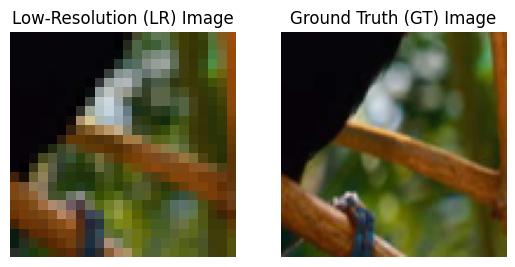

In [ ]:
# Assuming processed_images is your list of LR and GT patches
random_pair = random.choice(processed_test_set5_images)
LR_patch, GT_patch = random_pair

# Plot LR image
plt.subplot(1, 2, 1)
plt.imshow(LR_patch.permute(1, 2, 0))  # Permute LR image dimensions to (height, width, channels) and plot
plt.title('Low-Resolution (LR) Image')
plt.axis('off')

print(LR_patch.size())
# Plot GT image
plt.subplot(1, 2, 2)
plt.imshow(GT_patch.permute(1, 2, 0))  # Assuming GT image is also in (height, width, channels) format
plt.title('Ground Truth (GT) Image')
plt.axis('off')

plt.show()

### Putting images in DataLoader

In [ ]:
train_loader = DataLoader(processed_train_images, batch_size=batch_size)
test_set5_loader = DataLoader(processed_test_set5_images, batch_size=batch_size)
test_set14_loader = DataLoader(processed_test_set14_images, batch_size=batch_size)

### Defining Residual Block classes for Generator and Discriminator

In [ ]:
class ResBlockGenerator(nn.Module):
    def __init__(self):
        super(ResBlockGenerator, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same')
        # change momentum 0.5 -> 0.8
        self.batch_norm1 = nn.BatchNorm2d(64, momentum=0.5)
        self.p_relu = nn.PReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same')
        self.batch_norm2 = nn.BatchNorm2d(64, momentum=0.5)

    def forward(self, input_tensor):
        out = self.conv1(input_tensor)
        out = self.batch_norm1(out)
        out = self.p_relu(out)
        out = self.conv2(out)
        out = self.batch_norm2(out)
        out += input_tensor
        return out

### Defining Generator model

In [ ]:
class Generator(nn.Module):
    def __init__(self, num_residual_blocks = num_residual_blocks):
        super(Generator, self).__init__()
        # Pre residual layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding='same')
        self.p_relu1 = nn.PReLU()

        self.residual_blocks = nn.Sequential(
            *[ResBlockGenerator() for _ in range(num_residual_blocks)]
        )

        # Post residual layers
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same')
        self.batch_norm = nn.BatchNorm2d(64, momentum=0.5)

        # Upsampling layers
        self.upsample1 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding='same'),
            nn.PixelShuffle(2),
            nn.PReLU()
        )

        self.upsample2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding='same'),
            nn.PixelShuffle(2),
            nn.PReLU()
        )

        # Output convolutional layer
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding='same')

    def forward(self, input_tensor):
        out = self.conv1(input_tensor)
        out = self.p_relu1(out)
        input_residual_tensor = out.clone()

        for res_block in self.residual_blocks:
            out = res_block(out)

        out = self.conv2(out)
        out = self.batch_norm(out)
        out += input_residual_tensor

        out = self.upsample1(out)
        out = self.upsample2(out)

        out = self.conv3(out)
        return out


### Defining Discriminator model

In [ ]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channel,out_channel, strides = 1, padding_same=True):
        super(DiscriminatorBlock, self).__init__()

        if padding_same:
            self.padding = 'same'
        else:
            self.padding = 0

        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=strides, padding=self.padding)
        self.batch_normalization = nn.BatchNorm2d(out_channel, momentum=0.8)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, input_tensor):
        out = self.conv(input_tensor)
        out = self.batch_normalization(out)
        out = self.leaky_relu(out)
        return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding='same')
        self.leaky_relu1 = nn.LeakyReLU(0.2)

        self.block_with_batch_norm = nn.Sequential(
            DiscriminatorBlock(64, 64, strides=2, padding_same=False),
            DiscriminatorBlock(64, 128),
            DiscriminatorBlock(128, 128,strides=2, padding_same=False),
            DiscriminatorBlock(128, 256),
            DiscriminatorBlock(256, 256, strides=2, padding_same=False),
            DiscriminatorBlock(256, 512, ),
            DiscriminatorBlock(512, 512, strides=2, padding_same=False)
        )

        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(512 * 5 * 5, 1024)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.dense2 = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()



    def forward(self, input_tensor):
        out = self.conv1(input_tensor)
        out = self.leaky_relu1(out)
        out = self.block_with_batch_norm(out)
        out = self.flatten(out)
        out = self.dense1(out)
        out = self.leaky_relu2(out)
        out = self.dense2(out)
        out = self.sigmoid(out)
        return out

### Creating VGG loss function

In [ ]:
#phi_2,2, after 2nd activation, but before the 2nd max pooling

class VGG19Loss(nn.Module):
    # change to :9
    def __init__(self, layer_index=9):
        super(VGG19Loss, self).__init__()
        vgg19_model = vgg19(weights='DEFAULT')

        # vgg19_model.features.children() returns an iterator over each individual layer
        # list() converts the iterator into a Python list
        # [:layer_index + 1] slices the list up to and including the layer at layer_index
        # * is the unpacking operator, which makes the list elements suitable to be passed to nn.Sequential


        self.features = nn.Sequential(*list(vgg19_model.features.children())[:layer_index + 1])

        # Make sure no updating of the parameters occur
        for param in self.features.parameters():
            param.requires_grad = False

        self.criterion = nn.MSELoss()

    def forward(self, sr, hr):
        sr_features = self.features(sr)
        hr_features = self.features(hr)

        loss = self.criterion(sr_features, hr_features)

        return loss

### Defining generator, discriminator and VGG loss

In [ ]:
generator = Generator(num_residual_blocks=16)
discriminator = Discriminator()
vgg_loss = VGG19Loss()

generator.to(device)
discriminator.to(device)
vgg_loss.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 66.4MB/s]


VGG19Loss(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (criterion): MSELoss()
)

### Defining optimizers and loss functions

In [ ]:
optimizer_generator = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=5e-5, betas=(0.9, 0.999))

scheduler_generator = ReduceLROnPlateau(optimizer_generator, mode='min', factor=0.5, patience=5, verbose=True)
scheduler_discriminator = ReduceLROnPlateau(optimizer_discriminator, mode='min', factor=0.5, patience=5, verbose=True)

adversarial_criterion = nn.BCELoss()
pixel_criterion = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### Training loop

### Training loop with num of discriminator update per generator update

In [ ]:
n_critic = 5  # Number of discriminator updates per generator update
num_epochs = 7

for epoch in range(num_epochs):
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch}/{num_epochs}', position=0, leave=True) as pbar_epoch:
        for i, (imgs_lr, imgs_hr) in enumerate(train_loader):
            imgs_lr = imgs_lr * 2 - 1  # Normalize to [-1, 1]
            imgs_hr = imgs_hr * 2 - 1  # Normalize to [-1, 1]

            imgs_lr = imgs_lr.to(device)
            imgs_hr = imgs_hr.to(device)

            # Update Discriminator n_critic times
            for _ in range(n_critic):
                optimizer_discriminator.zero_grad()

                # Training the discriminator with real images
                outputs_real = discriminator(imgs_hr)
                real_labels = torch.ones((imgs_hr.size(0), 1), requires_grad=False).to(device)
                fake_labels = torch.zeros((imgs_hr.size(0), 1), requires_grad=False).to(device)
                loss_real = adversarial_criterion(outputs_real, real_labels)

                # Training generator with low resolution images
                fake_hr = generator(imgs_lr).detach()
                fake_hr_resized = F.interpolate(fake_hr, size=(96, 96), mode='bicubic', align_corners=False)
                outputs_fake = discriminator(fake_hr_resized)
                loss_fake = adversarial_criterion(outputs_fake, fake_labels)

                loss_discriminator = (loss_real + loss_fake) / 2
                loss_discriminator.backward()

                optimizer_discriminator.step()

            # Update Generator
            optimizer_generator.zero_grad()
            fake_hr = generator(imgs_lr)
            fake_hr_resized = F.interpolate(fake_hr, size=(96, 96), mode='bicubic', align_corners=False)
            outputs_fake = discriminator(fake_hr_resized)
            adversarial_loss = adversarial_criterion(outputs_fake, real_labels)

            pixel_loss = pixel_criterion(fake_hr_resized, imgs_hr)
            perceptual_loss = vgg_loss(fake_hr_resized, imgs_hr)
            perceptual_adversarial_loss = perceptual_loss + 0.001 * adversarial_loss

            total_loss = pixel_loss + perceptual_adversarial_loss
            total_loss.backward()
            optimizer_generator.step()

            pbar_epoch.update(1)
            pbar_epoch.set_postfix({'Discriminator loss': loss_discriminator.item(), 'Generator loss': total_loss.item()})

        scheduler_generator.step(total_loss)
        scheduler_discriminator.step(loss_discriminator)
        generator_best = generator.state_dict()
        generator.load_state_dict(generator_best)
        torch.save(generator.state_dict(), 'SRGAN.pth')

    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {loss_discriminator.item():.4f}] [G loss: {total_loss.item():.4f}] "
              f"[Pixel loss: {pixel_loss.item():.4f}] [VGG loss: {perceptual_loss.item():.4f}] "
              f"[Adversarial loss: {adversarial_loss.item():.4f}]")

Epoch 0/7:  14%|█▎        | 186/1375 [01:20<08:35,  2.31it/s, Discriminator loss=3.46e-6, Generator loss=0.559]


KeyboardInterrupt: 

In [ ]:
def load_generator_model(model_path):
    model = Generator(num_residual_blocks).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

model = load_generator_model('SRGAN.pth')

In [ ]:
# Function to process and save image
def process_and_save_image(input_image_path, output_image_path):
    input_image = cv2.imread(input_image_path)  # Read input image

    # Convert from BGR to RGB
    input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

    # Convert image to tensor and normalize to [-1. 1]
    input_tensor = torch.tensor(input_image_rgb, dtype=torch.float32).permute(2, 0, 1)/255.0
    input_tensor = input_tensor  * 2 -1

    # Add batch dimension
    input_tensor = input_tensor.unsqueeze(0)

    input_tensor = input_tensor.cuda()

    generator.eval()

    # Perform inference
    with torch.no_grad():
        SR_tensor = generator(input_tensor)

    # Post-process SR tensor
    SR_tensor = SR_tensor.squeeze().permute(1, 2, 0).cpu().numpy()  # Remove batch dimension, permute to HWC
    SR_tensor = np.clip((SR_tensor+1) /2 * 255.0, 0, 255).astype(np.uint8)  # Rescale to [0, 255] and convert to uint8

    # Resize the output image by reducing it to one-fourth of its original dimensions
    SR_tensor_resized = cv2.resize(SR_tensor, (SR_tensor.shape[1] // 4, SR_tensor.shape[0] // 4), interpolation=cv2.INTER_CUBIC)

    # Save the super-resolved image
    cv2.imwrite(output_image_path, cv2.cvtColor(SR_tensor_resized, cv2.COLOR_RGB2BGR))
    print(f"Processed and saved: {output_image_path}")

# Create output directory if it doesn't exist
input_dir = 'data/Test/Set5'
output_dir = 'results/Set5'
os.makedirs(output_dir, exist_ok=True)

# Process all images in the specified input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.bmp'):
        input_image_path = os.path.join(input_dir, filename)
        output_image_path = os.path.join(output_dir, filename)
        process_and_save_image(input_image_path, output_image_path)

Processed and saved: results/Set5/butterfly_GT.bmp
Processed and saved: results/Set5/baby_GT.bmp
Processed and saved: results/Set5/bird_GT.bmp
Processed and saved: results/Set5/head_GT.bmp
Processed and saved: results/Set5/woman_GT.bmp


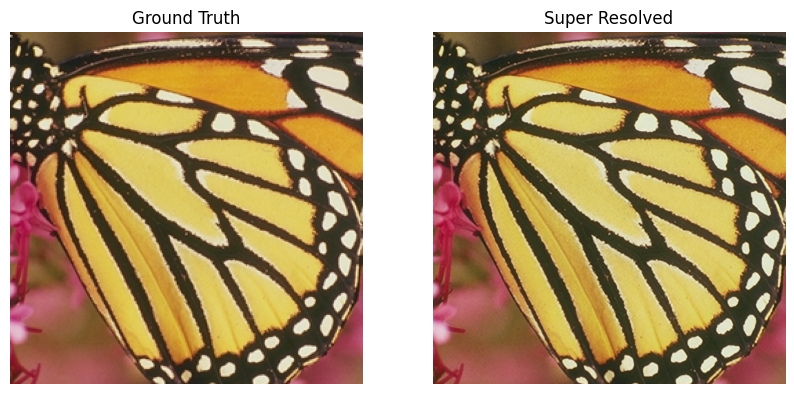

In [ ]:
import os
import cv2
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

# Function to process and display image
def process_and_display_image(input_image_path):
    input_image = cv2.imread(input_image_path)  # Read input image

    # Convert from BGR to RGB
    input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

    # Convert image to tensor and normalize to [-1, 1]
    input_tensor = torch.tensor(input_image_rgb, dtype=torch.float32).permute(2, 0, 1) / 255.0
    input_tensor = input_tensor * 2 - 1

    # Add batch dimension
    input_tensor = input_tensor.unsqueeze(0).cuda()

    generator.eval()

    # Perform inference
    with torch.no_grad():
        SR_tensor = generator(input_tensor)

    # Post-process SR tensor
    SR_tensor = SR_tensor.squeeze().permute(1, 2, 0).cpu().numpy()  # Remove batch dimension, permute to HWC
    SR_tensor = np.clip((SR_tensor + 1) / 2 * 255.0, 0, 255).astype(np.uint8)  # Rescale to [0, 255] and convert to uint8

    # Resize the output image by reducing it to one-fourth of its original dimensions
    #SR_tensor_resized = cv2.resize(SR_tensor, (SR_tensor.shape[1] // 4, SR_tensor.shape[0] // 4), interpolation=cv2.INTER_CUBIC)

    # Display the images side by side with ground truth on the left and super-resolved on the right
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(input_image_rgb)
    axes[0].set_title('Ground Truth')
    axes[1].imshow(SR_tensor)
    axes[1].set_title('Super Resolved')
    for ax in axes:
        ax.axis('off')
    plt.show()

# Directory containing input images
input_dir = 'data/Test/Set5'

# Select a random image from the input directory
filenames = [f for f in os.listdir(input_dir) if f.endswith('.bmp')]
random_filename = random.choice(filenames)
input_image_path = os.path.join(input_dir, random_filename)

# Process and display the random image
process_and_display_image(input_image_path)


In [ ]:
# Load your images (original and generated) as numpy arrays
img1 = imread('data/Test/Set14/barbara.bmp')  # Ground truth image
img2 = imread('results/Set14/barbara.bmp')  # Generated image (SRGAN output)

# Ensure images are in [0, 255] range
if img1.max() <= 1: img1 = (img1 * 255).astype(np.uint8)
if img2.max() <= 1: img2 = (img2 * 255).astype(np.uint8)

# Calculate PSNR
psnr_value = peak_signal_noise_ratio(img1, img2, data_range=255)

# Calculate SSIM
ssim_value, _ = structural_similarity(img1, img2, full=True, multichannel=True, win_size=3)

print(f'PSNR: {psnr_value:.4f}')
print(f'SSIM: {ssim_value:.4f}')

PSNR: 33.0131
SSIM: 0.9758


# Calculate the average PSNR and SSIM value for test Set 14 and Set 15

In [ ]:
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread

def calculate_average_psnr_ssim(test_dir, results_dir):
    psnr_total = 0
    ssim_total = 0
    num_images = 0

    # Get the list of image filenames in the test directory
    test_filenames = set(os.listdir(test_dir))
    results_filenames = set(os.listdir(results_dir))

    # Only compare files that are present in both directories
    common_filenames = test_filenames.intersection(results_filenames)

    for filename in common_filenames:
        # Construct full paths for the ground truth and generated images
        img1_path = os.path.join(test_dir, filename)
        img2_path = os.path.join(results_dir, filename)

        # Load the images as numpy arrays
        img1 = imread(img1_path)  # Ground truth image
        img2 = imread(img2_path)  # Generated image (SRGAN output)

        # Ensure images are in [0, 255] range
        if img1.max() <= 1: img1 = (img1 * 255).astype(np.uint8)
        if img2.max() <= 1: img2 = (img2 * 255).astype(np.uint8)

        # Skip images with different dimensions
        if img1.shape != img2.shape:
            print(f'Skipping {filename}: Dimension mismatch (img1: {img1.shape}, img2: {img2.shape})')
            continue

        # Calculate PSNR
        psnr_value = peak_signal_noise_ratio(img1, img2, data_range=255)

        # Calculate SSIM
        ssim_value, _ = structural_similarity(img1, img2, full=True, multichannel=True, win_size=3)

        # Accumulate PSNR and SSIM
        psnr_total += psnr_value
        ssim_total += ssim_value
        num_images += 1

    # Calculate average PSNR and SSIM
    avg_psnr = psnr_total / num_images if num_images > 0 else 0
    avg_ssim = ssim_total / num_images if num_images > 0 else 0

    return avg_psnr, avg_ssim

# Example usage
test_dir_set14 = 'data/Test/Set14'
results_dir_set14 = 'results/Set14'

avg_psnr_set14, avg_ssim_set14 = calculate_average_psnr_ssim(test_dir_set14, results_dir_set14)
print(f'Average PSNR Set 14: {avg_psnr_set14:.4f}')
print(f'Average SSIM Set 14: {avg_ssim_set14:.4f}')

test_dir_set5 = 'data/Test/Set5'
results_dir_set5 = 'results/Set5'
avg_psnr_set5, avg_ssim_set5 = calculate_average_psnr_ssim(test_dir_set5, results_dir_set5)
print(f'Average PSNR Set 5: {avg_psnr_set5:.4f}')
print(f'Average SSIM Set 14: {avg_ssim_set5:.4f}')


avg_psnr = (avg_psnr_set14 + avg_psnr_set5)/2
avg_ssim = (avg_ssim_set14 + avg_ssim_set5)/2
print(f'Average PSNR: {avg_psnr:.4f}')
print(f'Average SSIM: {avg_ssim:.4f}')


Skipping bridge.bmp: Dimension mismatch (img1: (512, 512), img2: (512, 512, 3))
Average PSNR Set 14: 32.5344
Average SSIM Set 14: 0.9595
Average PSNR Set 5: 33.8143
Average SSIM Set 14: 0.9654
Average PSNR: 33.1743
Average SSIM: 0.9624


In [ ]:
import shutil
from google.colab import files

# Create a ZIP file
folder_to_zip = 'results'
zip_file = 'results_srgan.zip'
shutil.make_archive(zip_file.replace('.zip', ''), 'zip', folder_to_zip)



'/content/results_srgan.zip'